In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist  # <-- attention: 'mnist' (pas 'minst')
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
# Pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Charger les données
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Shapes:")
print("  x_train:", x_train.shape, "y_train:", y_train.shape)
print("  x_test :", x_test.shape,  "y_test :", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes:
  x_train: (60000, 28, 28) y_train: (60000,)
  x_test : (10000, 28, 28) y_test : (10000,)


# **Exercice 1 (Keras)**

In [3]:
# Distribution des classes (ensemble d'entraînement)
dist = pd.Series(y_train).value_counts().sort_index()
print("\nDistribution des classes (train):")
print(dist)


Distribution des classes (train):
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


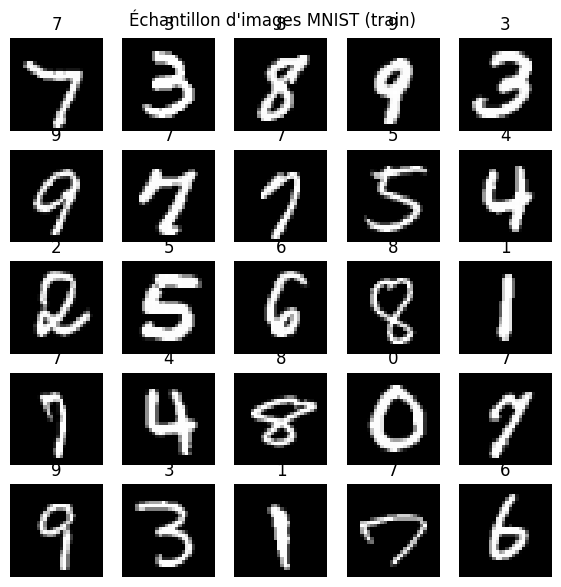

In [4]:
# Visualisation : un échantillon d’images (5x5)
plt.figure(figsize=(7,7))
idxs = np.random.choice(len(x_train), size=25, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(int(y_train[idx]))
    plt.axis('off')
plt.suptitle("Échantillon d'images MNIST (train)", y=0.92)
plt.show()

In [5]:
# Normalisation en [0,1] et ajout du canal (28,28) -> (28,28,1)
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

print("Nouvelles shapes:")
print("  x_train:", x_train.shape, "x_test:", x_test.shape)

Nouvelles shapes:
  x_train: (60000, 28, 28, 1) x_test: (10000, 28, 28, 1)


In [6]:
# ====== Hyperparamètres ======
batch_size = 128
epochs = 12
learning_rate = 1e-3

# ====== Modèle CNN ======

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(5,5), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, kernel_size=(5,5), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, kernel_size=(5,5), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.summary()

# Compilation
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy",  # labels {0..9} -> pas besoin de one-hot
              metrics=["accuracy"])

I0000 00:00:1755958791.867176      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755958791.867945      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,270 (833.09 KB)

 Trainable params: 213,270 (833.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12


I0000 00:00:1755958796.355021      98 service.cc:148] XLA service 0x7a9908006ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755958796.356644      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755958796.356662      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755958796.703115      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755958800.194841      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 - 12s - 28ms/step - accuracy: 0.9384 - loss: 0.2055 - val_accuracy: 0.9770 - val_loss: 0.0790
Epoch 2/12
422/422 - 3s - 6ms/step - accuracy: 0.9834 - loss: 0.0516 - val_accuracy: 0.9858 - val_loss: 0.0535
Epoch 3/12
422/422 - 3s - 6ms/step - accuracy: 0.9897 - loss: 0.0329 - val_accuracy: 0.9893 - val_loss: 0.0416
Epoch 4/12
422/422 - 3s - 6ms/step - accuracy: 0.9922 - loss: 0.0237 - val_accuracy: 0.9898 - val_loss: 0.0393
Epoch 5/12
422/422 - 3s - 6ms/step - accuracy: 0.9937 - loss: 0.0196 - val_accuracy: 0.9902 - val_loss: 0.0350
Epoch 6/12
422/422 - 3s - 6ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9890 - val_loss: 0.0460
Epoch 7/12
422/422 - 3s - 6ms/step - accuracy: 0.9959 - loss: 0.0124 - val_accuracy: 0.9887 - val_loss: 0.0466
Epoch 8/12
422/422 - 3s - 6ms/step - accuracy: 0.9962 - loss: 0.0110 - val_accuracy: 0.9903 - val_loss: 0.0429
Epoch 9/12
422/422 - 3s - 6ms/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.9912 - val_loss: 0.0384
Epoch 10/1

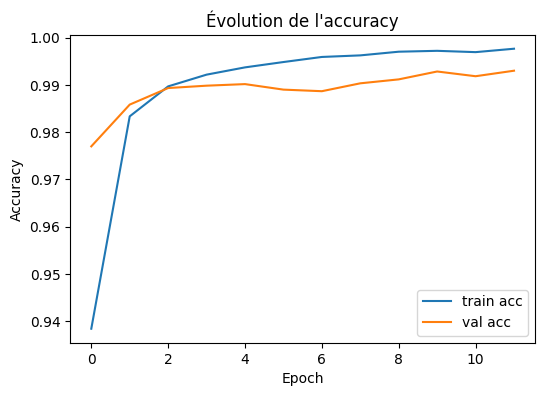

In [7]:
# Callbacks utiles (facultatifs)
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[earlystop],
    verbose=2
)

# Courbes d'apprentissage (optionnel)
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Évolution de l'accuracy")
plt.show()


Test accuracy: 0.9923 | Test loss: 0.0356
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


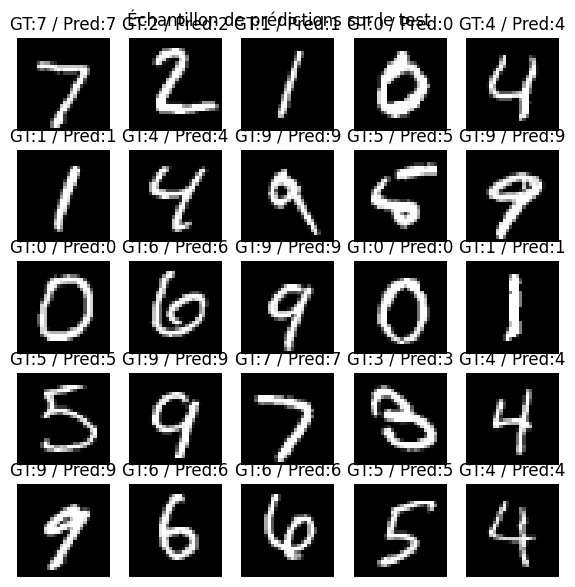

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Afficher quelques prédictions (optionnel)
preds = model.predict(x_test[:25])
y_pred = np.argmax(preds, axis=1)

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"GT:{y_test[i]} / Pred:{y_pred[i]}")
    plt.axis('off')
plt.suptitle("Échantillon de prédictions sur le test", y=0.92)
plt.show()


In [10]:
# Prédictions sur tout l'ensemble de test (plus rapide avec un batch_size élevé)
y_proba = model.predict(x_test, batch_size=1024, verbose=0)
y_pred  = np.argmax(y_proba, axis=1)

# Rapport de classification (précision, rappel, f1-score par classe)
print("=== Classification Report (test) ===")
print(classification_report(y_test, y_pred, digits=4))

=== Classification Report (test) ===
              precision    recall  f1-score   support

           0     0.9969    0.9969    0.9969       980
           1     0.9939    0.9982    0.9960      1135
           2     0.9885    0.9952    0.9918      1032
           3     0.9863    0.9970    0.9916      1010
           4     0.9899    0.9959    0.9929       982
           5     0.9877    0.9922    0.9899       892
           6     0.9989    0.9812    0.9900       958
           7     0.9922    0.9893    0.9907      1028
           8     0.9949    0.9918    0.9933       974
           9     0.9940    0.9841    0.9890      1009

    accuracy                         0.9923     10000
   macro avg     0.9923    0.9922    0.9922     10000
weighted avg     0.9923    0.9923    0.9923     10000



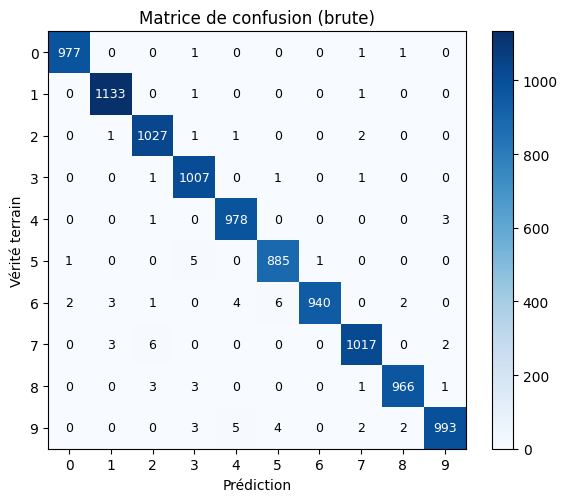

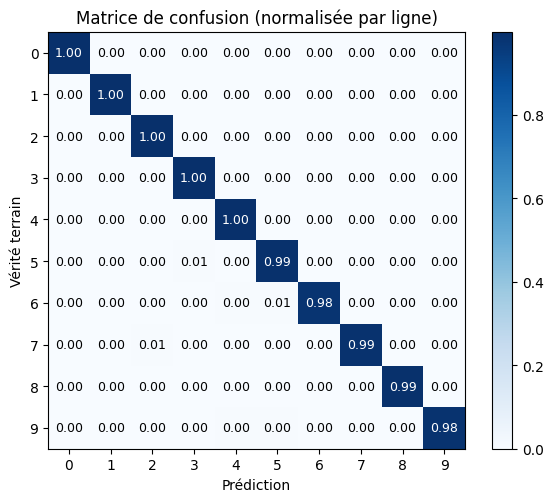

In [11]:
# Matrice de confusion (brute) et normalisée
cm = confusion_matrix(y_test, y_pred, labels=np.arange(10))

def plot_cm(mat, title, normalize=False):
    data = mat.astype(float).copy()
    if normalize:
        # Normalisation par ligne (rappel par classe)
        data = data / (data.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(6,5))
    plt.imshow(data, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédiction')

    # Annotations des cases
    thresh = data.max() / 2.0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = f"{data[i, j]:.2f}" if normalize else f"{int(mat[i, j])}"
            plt.text(j, i, text,
                     ha="center", va="center",
                     color="white" if data[i, j] > thresh else "black",
                     fontsize=9)
    plt.tight_layout()
    plt.show()

plot_cm(cm, "Matrice de confusion (brute)", normalize=False)
plot_cm(cm, "Matrice de confusion (normalisée par ligne)", normalize=True)


In [12]:
import pandas as pd

support = cm.sum(axis=1)
per_class_recall = np.diag(cm) / (support + 1e-12)

df_per_class = pd.DataFrame({
    "classe": np.arange(10),
    "support": support.astype(int),
    "rappel (recall)": per_class_recall.round(4)
})
print(df_per_class)

   classe  support  rappel (recall)
0       0      980           0.9969
1       1     1135           0.9982
2       2     1032           0.9952
3       3     1010           0.9970
4       4      982           0.9959
5       5      892           0.9922
6       6      958           0.9812
7       7     1028           0.9893
8       8      974           0.9918
9       9     1009           0.9841


# **Exercice 2 PyTorch** 

In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Reproductibilité
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.78MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.67MB/s]


Distribution des classes (train):
 0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


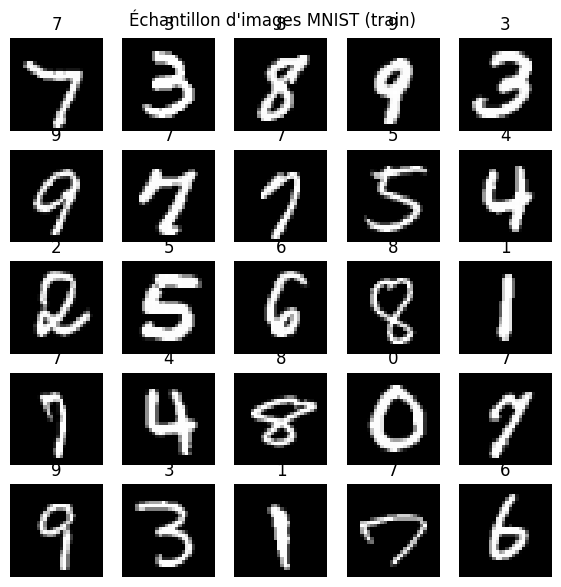

In [2]:
# Normalisation standard MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                              # -> [0,1]
    transforms.Normalize((0.1307,), (0.3081,))         # centrage / écart-type
])

# Téléchargement MNIST
train_full = datasets.MNIST(root="./data", train=True,  transform=transform, download=True)
test_set   = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split train/val (90% / 10%)
val_ratio = 0.1
n_total   = len(train_full)
n_val     = int(n_total * val_ratio)
n_train   = n_total - n_val
train_set, val_set = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Distribution des classes (sur le vrai train original pour simplicité)
dist = pd.Series(train_full.targets.numpy()).value_counts().sort_index()
print("Distribution des classes (train):\n", dist)

# Visualisation de 25 images du train
plt.figure(figsize=(7,7))
idxs = np.random.choice(len(train_full.data), size=25, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(5,5,i+1)
    plt.imshow(train_full.data[idx].numpy(), cmap="gray")
    plt.title(int(train_full.targets[idx]))
    plt.axis("off")
plt.suptitle("Échantillon d'images MNIST (train)", y=0.92)
plt.show()

In [3]:
class MNIST_CNN(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # same padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # 64 x 3 x 3 = 576
            nn.Linear(64*3*3, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)           # logits (pas de softmax ici)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MNIST_CNN().to(device)
model


MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [4]:
from torch.cuda.amp import autocast, GradScaler

epochs        = 12
learning_rate = 1e-3
weight_decay  = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler    = GradScaler(enabled=(device.type == "cuda"))  # AMP

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        acc  = accuracy_from_logits(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        n += bs
    return total_loss / n, total_acc / n

train_hist, val_hist = [], []
best_val_acc, best_state = 0.0, None

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_acc, seen = 0.0, 0.0, 0

    for x, y in train_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy_from_logits(logits.detach(), y)
        bs = x.size(0)
        running_loss += loss.item() * bs
        running_acc  += acc * bs
        seen += bs

    train_loss = running_loss / seen
    train_acc  = running_acc  / seen
    val_loss, val_acc = evaluate(val_loader)

    train_hist.append((train_loss, train_acc))
    val_hist.append((val_loss, val_acc))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state   = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

# Restaurer le meilleur modèle (validation)
if best_state is not None:
    model.load_state_dict(best_state)


/tmp/ipykernel_36/2235210249.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler(enabled=(device.type == "cuda"))  # AMP
/tmp/ipykernel_36/2235210249.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Epoch 01 | train loss 0.2156 acc 0.9331 | val loss 0.0707 acc 0.9773
Epoch 02 | train loss 0.0474 acc 0.9850 | val loss 0.0612 acc 0.9842
Epoch 03 | train loss 0.0327 acc 0.9895 | val loss 0.0415 acc 0.9873
Epoch 04 | train loss 0.0236 acc 0.9924 | val loss 0.0406 acc 0.9885
Epoch 05 | train loss 0.0198 acc 0.9941 | val loss 0.0380 acc 0.9888
Epoch 06 | train loss 0.0160 acc 0.9945 | val loss 0.0401 acc 0.9873
Epoch 07 | train loss 0.0140 acc 0.9955 | val loss 0.0443 acc 0.9882
Epoch 08 | train loss 0.0130 acc 0.9957 | val loss 0.0326 acc 0.9902
Epoch 09 | train loss 0.0095 acc 0.9970 | val loss 0.0396 acc 0.9882
Epoch 10 | train loss 0.0099 acc 0.9966 | val loss 0.0444 acc 0.9893
Epoch 11 | train loss 0.0098 acc 0.9968 | val loss 0.0299 acc 0.9922
Epoch 12 | train loss 0.0073 acc 0.9975 | val loss 0.0527 acc 0.9887


In [5]:
test_loss, test_acc = evaluate(test_loader)
print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

Test — loss: 0.0265 | acc: 0.9934


=== Classification Report (test) ===
              precision    recall  f1-score   support

           0     0.9949    0.9959    0.9954       980
           1     0.9947    0.9965    0.9956      1135
           2     0.9952    0.9952    0.9952      1032
           3     0.9912    0.9980    0.9946      1010
           4     0.9929    0.9980    0.9954       982
           5     0.9877    0.9933    0.9905       892
           6     0.9968    0.9864    0.9916       958
           7     0.9951    0.9854    0.9902      1028
           8     0.9928    0.9969    0.9949       974
           9     0.9920    0.9881    0.9901      1009

    accuracy                         0.9934     10000
   macro avg     0.9933    0.9934    0.9933     10000
weighted avg     0.9934    0.9934    0.9934     10000



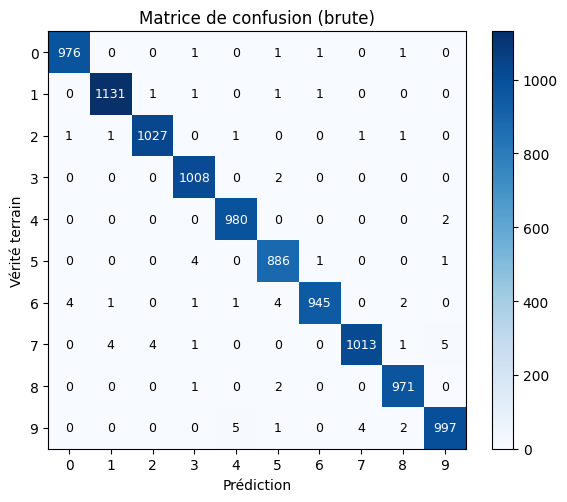

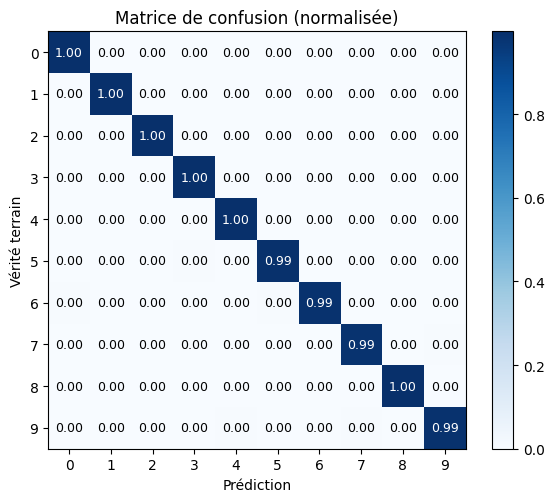

In [6]:
# !pip install -q scikit-learn
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_all(loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.append(y.numpy())
        y_pred.append(preds)
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true, y_pred = predict_all(test_loader)

print("=== Classification Report (test) ===")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))

def plot_cm(mat, title, normalize=False):
    data = mat.astype(float).copy()
    if normalize:
        data = data / (data.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(6,5))
    plt.imshow(data, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.ylabel('Vérité terrain'); plt.xlabel('Prédiction')

    thresh = data.max() / 2.0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = f"{data[i, j]:.2f}" if normalize else f"{int(mat[i, j])}"
            plt.text(j, i, text, ha="center", va="center",
                     color="white" if data[i, j] > thresh else "black", fontsize=9)
    plt.tight_layout()
    plt.show()

plot_cm(cm, "Matrice de confusion (brute)", normalize=False)
plot_cm(cm, "Matrice de confusion (normalisée)", normalize=True)


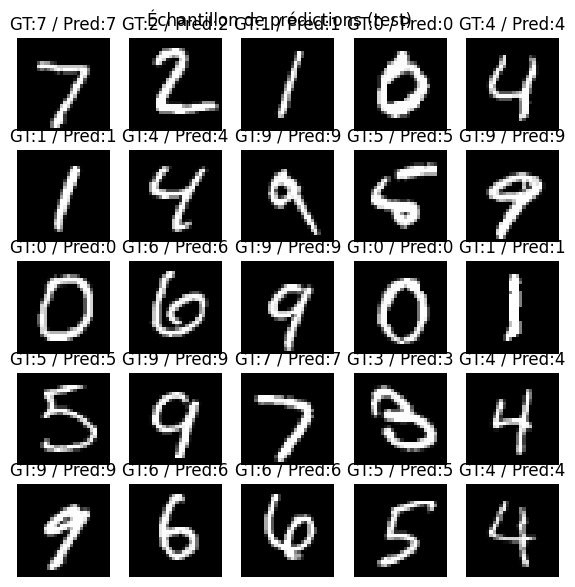

In [7]:
# Montrer 25 images de test avec prédictions
images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
with torch.no_grad():
    logits = model(images.to(device))
preds = logits.argmax(dim=1).cpu().numpy()

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].squeeze().numpy() * 0.3081 + 0.1307, cmap="gray")  # "dé-normalisé" approx pour affichage
    plt.title(f"GT:{labels[i].item()} / Pred:{preds[i]}")
    plt.axis("off")
plt.suptitle("Échantillon de prédictions (test)", y=0.92)
plt.show()
